## Compare different methods for estimating time scales

1. Whittle w/ gamma-exp*cosine\
2. Whittle w/ Lorentzian
3. Parametric ACF LSQ (Lorentzian
4. Parametric ACF MLE (Lorentzian)
5. Spectral density

In [4]:
import sfoda.suntans.sunxarray as sxr

import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cmocean import cm
from s3fs import S3FileSystem, S3Map
from tqdm import tqdm

In [57]:
import nonstat_itides_jax as nsjax

import nonstat_itides as nsit

from utils import filt_decompose

In [6]:
# s3login = '/home/mrayson/code/s3.acacia.login'
s3login = '/home/jupyter-mrayson/s3.acacia.login'

with open(s3login) as f:
    lines = f.readlines()

url, key, secret = [ff.strip('\n') for ff in lines[0:3]]
s3 = S3FileSystem(client_kwargs={'endpoint_url':url},
            key=key,
            secret=secret)

In [7]:
###
has_gamma = True
paramsfile1 = '../DATA/NWS_2km_GLORYS_nonstat_itide_params_seasonaltides_meso_M2S2_vc.nc'
scenario1 = 'seasonaltides_meso_M2S2_vc'

has_gamma = False
paramsfile2 = '../DATA/NWS_2km_GLORYS_nonstat_itide_params_seasonaltides_meso_M2S2_gamma_1_0_vc.nc'
scenario2 = 'seasonaltides_meso_M2S2_gamma_1_0_vc'

units='cm s$^{-1}$'
vmax=5.
varname='vc'


In [8]:
ds_params1 = xr.open_dataset(paramsfile1, engine='h5netcdf')
# These need filling in??
ds_params1.suntans.xv=ds_params1.xv.values
ds_params1.suntans.yv=ds_params1.yv.values

ds_params2 = xr.open_dataset(paramsfile2, engine='h5netcdf')
# These need filling in??
ds_params2.suntans.xv=ds_params2.xv.values
ds_params2.suntans.yv=ds_params2.yv.values

ds_params1

Changing the _FillValue from -999999 to 999999
Changing the _FillValue from -999999 to 999999


<xarray.Dataset>
Dimensions:  (Nc: 225368, numsides: 8, params: 9, Nk: 80, time: 8761, Np: 454016)
Coordinates:
  * time     (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-07-01
    z_r      (Nk) float64 ...
Dimensions without coordinates: Nc, numsides, params, Nk, Np
Data variables:
    cells    (Nc, numsides) int32 3058 3061 3060 2801 ... 316184 316187 -1 -1
    data     (Nc, params) float64 ...
    dv       (Nc) float64 ...
    dz       (Nk) float64 ...
    nfaces   (Nc) int32 6 6 6 6 6 6 6 6 6 6 6 6 6 ... 6 6 6 6 6 6 6 6 6 6 6 6 6
    xp       (Np) float64 125.2 114.2 136.3 125.4 ... 117.0 117.0 117.1 117.1
    xv       (Nc) float64 109.0 109.1 109.1 109.2 ... 117.7 117.7 117.7 117.9
    yp       (Np) float64 -14.48 -22.48 -13.24 -14.54 ... -18.27 -18.27 -18.26
    yv       (Nc) float64 -19.4 -19.5 -19.61 -19.71 ... -13.1 -13.12 -13.07
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

In [91]:

def plot_site(ds_data, ds_params, xpt, ypt, acffunc, ax, c='k'):
    data_pt = nsit.extract_point(ds_data, xpt, ypt)
    tdays = (data_pt.time-data_pt.time[0]).values.astype(float)/1e9/86400
    dt = tdays[2]-tdays[1]
    params_pt = nsit.extract_point(ds_params, xpt, ypt)
    acf = acffunc(tdays, tdays[0], [ff for ff in params_pt['data'].data])

    #y = data_pt['eta_steric_non_phase_locked']
    #y = data_pt['eta_non_phase_locked']+data_pt['eta_phase_locked']
    y = data_pt['{}_non_phase_locked'.format(varname)]
    #y = data_pt['uc_non_phase_locked']

    #window=None
    window=hann(y.shape[0])
    
    #f, I =  nsit.periodogram(y, delta=dt, h=None)
    f, I2 =  nsit.periodogram(y, delta=dt, h=window)
    #f, I2 =  nsit.periodogram(y2, delta=dt)
    f_S, S = nsit.bochner(acf, delta=dt)
    
    ax.semilogy(f, 2*I2, c='b', lw=0.2)
    #plt.semilogy(f, I2, 'b', lw=0.2)
    ax.semilogy(f_S,S,c, ls='--', lw=2)
    ax.set_ylim(1e-7, 1e0)
    ax.set_xlim(1.6, 2.4)
    #plt.xlim(0.1, 6)
    
    ax.set_xlabel('f [cpd]')
    
    #print(np.exp(params_pt['data'][0:4].data))
    #print(np.exp(params_pt['data'][-1].data))
    #print(nsit.invlogit(params_pt['data'][4:6].data, scale=2))
    print(params_pt['data'].values)

    return y, dt, acf


In [74]:
datafile = ds_params1['data'].attrs['input file']
f = S3Map("uwaoceanprocesses-suntans/"+datafile, s3=s3)
ds_data = xr.open_dataset(f, engine='zarr', chunks={}, consolidated=False)

# These need filling in??
ds_data.suntans.xv=ds_data.xv.values
ds_data.suntans.yv=ds_data.yv.values

ds_data

Changing the _FillValue from -999999 to 999999


<xarray.Dataset>
Dimensions:              (Nc: 225368, numsides: 8, Nk: 80, time: 8761,
                          Np: 454016)
Coordinates:
  * time                 (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-0...
    z_r                  (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
Dimensions without coordinates: Nc, numsides, Nk, Np
Data variables:
    cells                (Nc, numsides) int32 dask.array<chunksize=(2000, 8), meta=np.ndarray>
    dv                   (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    dz                   (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    nfaces               (Nc) int32 dask.array<chunksize=(2000,), meta=np.ndarray>
    vc_non_phase_locked  (time, Nc) float64 dask.array<chunksize=(8761, 2000), meta=np.ndarray>
    vc_phase_locked      (time, Nc) float64 dask.array<chunksize=(8761, 2000), meta=np.ndarray>
    xp                   (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    xv                   (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    yp                   (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    yv                   (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

[ 0.1020309   9.7807951   0.91716141  0.02809921  0.01856671  6.7475667
 13.13326836  1.7397368   1.22453582]


ValueError: too many values to unpack (expected 2)

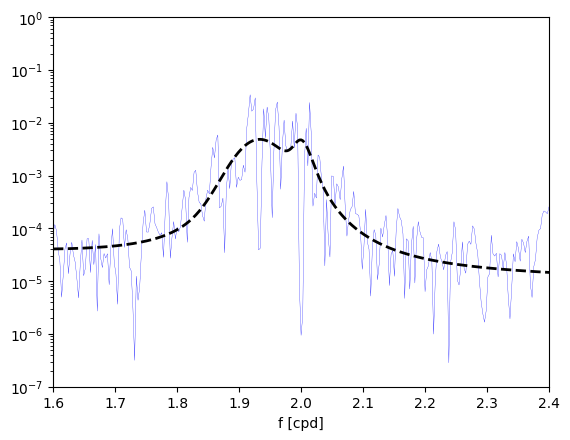

In [92]:
acffunc1 = nsjax.itide_M2S2_meso_gammaexp
acffunc2 = nsjax.itide_M2S2_meso_gammaexp_fixed
xpt, ypt = 123.2,-13.35
plt.figure()
ax=plt.subplot(111)
_,_=plot_site(ds_data, ds_params1, xpt, ypt, acffunc1, ax, c='k')
yd,dt, acf = plot_site(ds_data, ds_params2, xpt, ypt, acffunc2, ax, c='r')

In [ ]:
yd

In [ ]:
yd.plot()

Text(0.5, 0, 'f [cpd]')

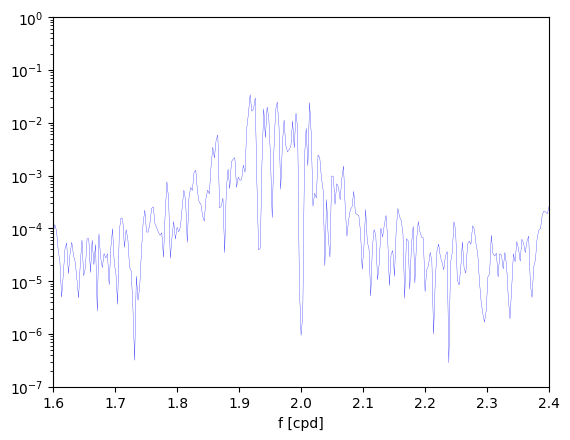

In [79]:
window=hann(yd.shape[0])
    
# f, I =  nsit.periodogram(yd, delta=dt, h=None)
f2, I2 =  nsit.periodogram(yd, delta=dt, h=window)

ax=plt.subplot(111)
ax.semilogy(f2, 2*I2, c='b', lw=0.2)
#plt.semilogy(f, I2, 'b', lw=0.2)
ax.set_ylim(1e-7, 1e0)
ax.set_xlim(1.6, 2.4)
#plt.xlim(0.1, 6)

ax.set_xlabel('f [cpd]')

[ 0.1020309   9.7807951   0.91716141  0.02809921  0.01856671  6.7475667
 13.13326836  1.7397368   1.22453582]
[ 0.10868705 10.53203583  1.04954743  0.02904875  0.01864847 16.45280266
 17.16510963]


Text(0.5, 0, 'f [cpd]')

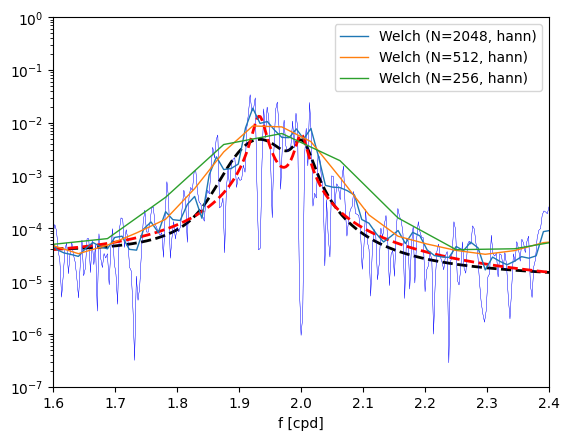

In [144]:
from scipy.signal import welch

N = yd.shape[0]

f, Iw = welch(yd.values, 1/dt, nperseg=N, window='boxcar')

ax=plt.subplot(111)
# ax.semilogy(f2, 2*I2, c='b', lw=0.2)
_,_, acf1=plot_site(ds_data, ds_params1, xpt, ypt, acffunc1, ax, c='k')
yd,dt, acf2 = plot_site(ds_data, ds_params2, xpt, ypt, acffunc2, ax, c='r')

# f, Iw = welch(yd.values, 1/dt, nperseg=N, window='boxcar')
# ax.semilogy(f, Iw, lw=0.5, label='Raw periodogram (boxcar)')

# f, Iw = welch(yd.values, 1/dt, nperseg=N, window='hann')
# ax.semilogy(f, Iw, lw=0.2, label='Raw periodogram (hann)')

f, Iw = welch(yd.values, 1/dt, nperseg=2048, window='hann')
ax.semilogy(f, Iw, lw=1., label='Welch (N=2048, hann)')


# f, Iw = welch(yd.values, 1/dt, nperseg=1024, window='hann')
# ax.semilogy(f, Iw, lw=1., label='Welch (N=1024, hann)')

f, Iw = welch(yd.values, 1/dt, nperseg=512, window='hann')
ax.semilogy(f, Iw, lw=1., label='Welch (N=512, hann)')

f, Iw = welch(yd.values, 1/dt, nperseg=256, window='hann')
ax.semilogy(f, Iw, lw=1., label='Welch (N=256, hann)')

plt.legend()
ax.set_ylim(1e-7, 1e0)
ax.set_xlim(1.6, 2.4)
#plt.xlim(0.1, 6)

ax.set_xlabel('f [cpd]')

In [81]:
#!pip install statsmodels
from statsmodels.tsa import stattools

(0.0, 336.0)

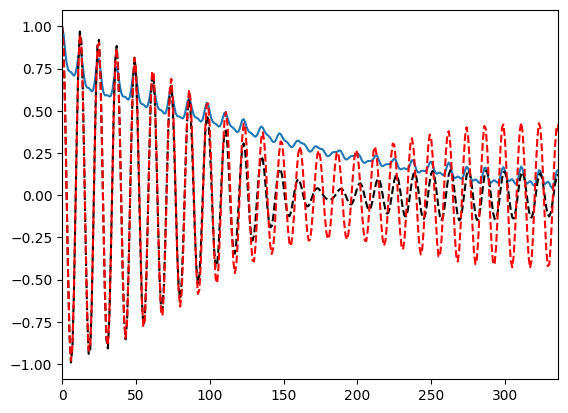

In [118]:
# acf, ci = stattools.acf(yf[:,1], nlags=14*24, alpha= 0.05, fft=False)
acf, ci = stattools.acf(yd, nlags=14*24, alpha= 0.05, fft=False)

ax=plt.subplot(111)
ax.plot(acf)
ax.plot(acf1/acf1[0],'k--')
ax.plot(acf2/acf2[0],'r--')

ax.set_xlim(0, 14*24)
# plt.fill_between(x=range(14*24), y1=ci)

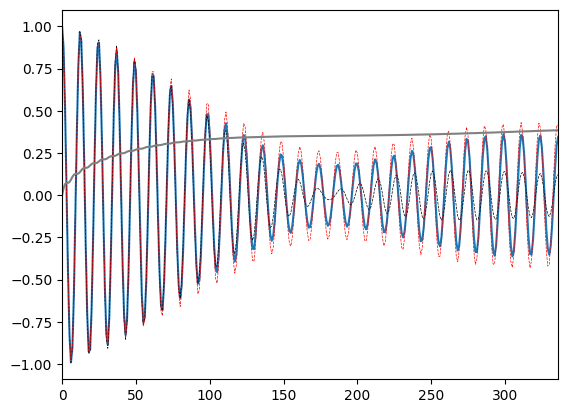

In [142]:
yf = filt_decompose(yd, dt*86400, b1=0.5*16*3600, b2 = 0.5*10*3600)
# yf = filt_decompose(yd, dt*86400, b1=30*3600, b2 = 4*3600)

nlags = 14*24
acf, ci = stattools.acf(yf[:,1], nlags=nlags, alpha= 0.05, fft=True)
# acf, ci = stattools.acf(yd, nlags=14*24, alpha= 0.05, fft=False)

tdays = (ds_data.time-ds_data.time[0]).values.astype(float)/1e9/86400
dt = tdays[2]-tdays[1]

params_pt = nsit.extract_point(ds_params1, xpt, ypt)
covparams = [ff for ff in params_pt['data'].data]
covparams[0] = 0 # No mesoscale
acf1 = acffunc1(tdays, tdays[0], covparams)

params_pt = nsit.extract_point(ds_params2, xpt, ypt)
covparams2 = [ff for ff in params_pt['data'].data]
covparams2[0] = 0 # No mesoscale
acf2 = acffunc2(tdays, tdays[0], covparams2)

ax=plt.subplot(111)
ax.plot(acf)
ax.plot(tdays*24,acf1/acf1[0],'k--', lw=0.5)
ax.plot(tdays*24,acf2/acf2[0],'r--', lw=0.5)
ax.set_xlim(0, nlags)
plt.plot(ci[:,1] - ci[:,0], '0.5')